<a href="https://colab.research.google.com/github/Sidharth-Darwin/PyTorch_Programs/blob/main/variable_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
data_root_path = "/content/data"

train_data = MNIST(root=data_root_path, train=True, transform=ToTensor(), download=True)
test_data = MNIST(root=data_root_path, train=False, transform=ToTensor(), download=True)

In [4]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [5]:
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
)

In [47]:
class VAE(nn.Module):
    def __init__(self, n_hidden_layers=400, n_bottleneck=20):
        super(VAE, self).__init__()
        self.n_hidden_layers = n_hidden_layers
        self.n_bottleneck = n_bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=self.n_hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=self.n_hidden_layers, out_features=2*self.n_bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.n_bottleneck, out_features=self.n_hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=self.n_hidden_layers, out_features=28*28)
        )

    def encode(self, input_data):
        input_data = input_data.view(-1, 28*28)
        out = self.encoder(input_data).view(-1, 2, self.n_bottleneck)
        mu = out[:, 0, :]
        logvar = out[:, 1, :]
        return mu, logvar

    def decode(self, input_data):
        return self.decoder(input_data)

    def reparametrize(self, mu, logvar):
        if self.training:
            sigma = logvar.mul(0.5).exp_()
            epsilon = torch.randn_like(sigma)
            return mu + sigma.mul(epsilon)
        else:
            return mu

    def forward(self, input_data):
        mu, logvar = self.encode(input_data)
        z = self.reparametrize(mu, logvar)
        return self.decode(z).view(-1, 1, 28, 28), mu, logvar

    def sample(self, n_samples):
        z = torch.randn((n_samples, self.n_bottleneck)).to(device)
        return self.decode(z).view(-1, 1, 28, 28)

In [48]:
model = VAE(n_hidden_layers=400, n_bottleneck=20).to(device)
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
  )
)

In [49]:
learning_rate = 3e-4
optimizer = Adam(model.parameters(), lr=learning_rate)

In [50]:
def loss_fn(x, x_hat, mu, logvar, beta=1):
    """
    x: input data
    x_hat: reconstructed input data
    mu: mean
    logvar: log variance
    """
    # BCE with logits used as reconstruction loss here.
    r_loss = F.binary_cross_entropy_with_logits(x_hat, x, reduction="sum")

    # KL Divergence loss.
    d_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return r_loss + beta * d_loss, r_loss.item(), d_loss.item()

In [51]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3)

Epoch 1:


1875it [00:33, 56.64it/s, divergence_loss=221, loss=5.52e+3, reconstruction_loss=4.64e+3]


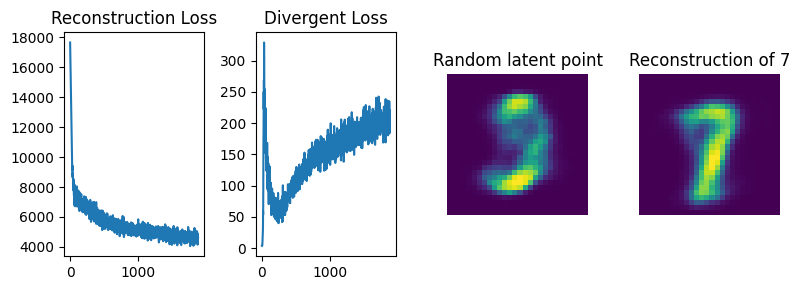

Epoch 2:


1875it [00:40, 46.73it/s, divergence_loss=240, loss=5.08e+3, reconstruction_loss=4.12e+3]


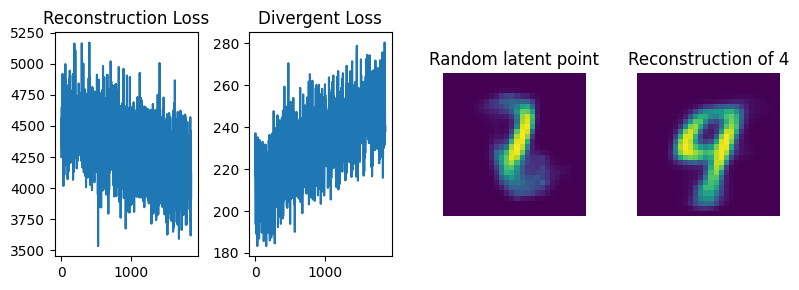

Epoch 3:


1875it [00:44, 42.59it/s, divergence_loss=254, loss=5.09e+3, reconstruction_loss=4.07e+3]


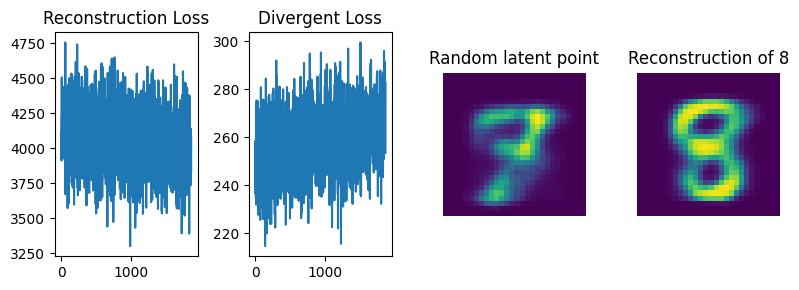

Epoch 4:


1875it [00:36, 50.84it/s, divergence_loss=253, loss=4.52e+3, reconstruction_loss=3.51e+3]


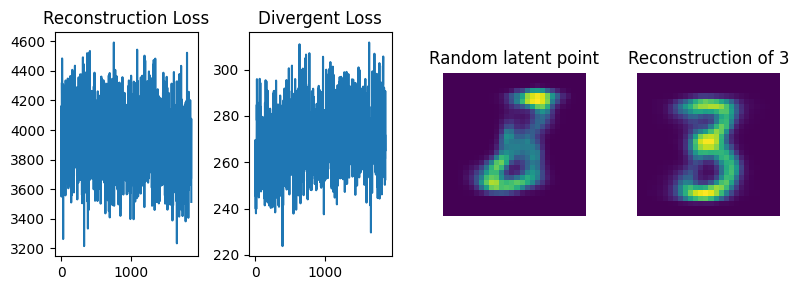

Epoch 5:


1875it [00:38, 49.20it/s, divergence_loss=285, loss=4.98e+3, reconstruction_loss=3.84e+3]


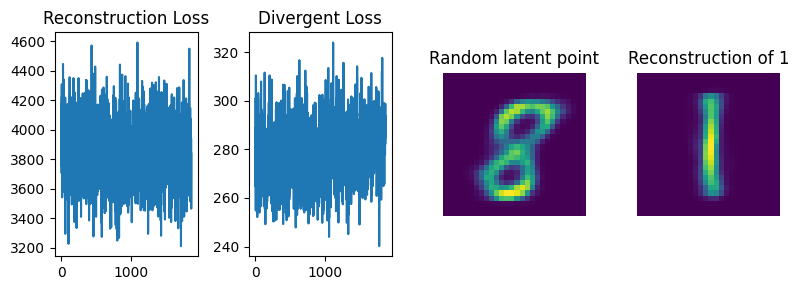

Epoch 6:


1875it [00:39, 47.48it/s, divergence_loss=296, loss=4.84e+3, reconstruction_loss=3.66e+3]


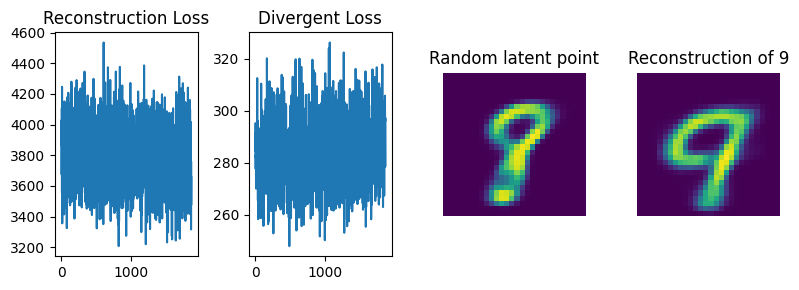

Epoch 7:


1875it [00:41, 45.08it/s, divergence_loss=286, loss=5.03e+3, reconstruction_loss=3.88e+3]


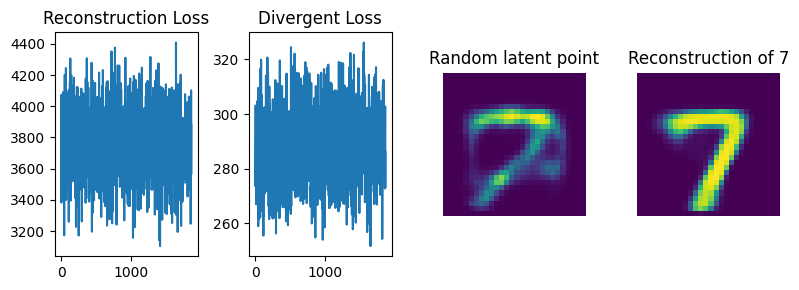

Epoch 8:


1875it [00:42, 44.43it/s, divergence_loss=284, loss=4.92e+3, reconstruction_loss=3.79e+3]


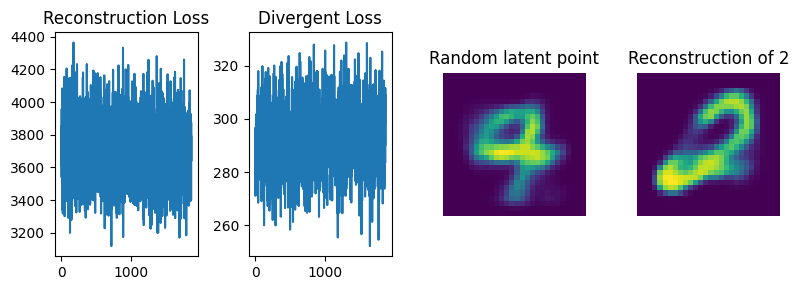

Epoch 9:


1875it [00:44, 42.21it/s, divergence_loss=288, loss=4.63e+3, reconstruction_loss=3.48e+3]


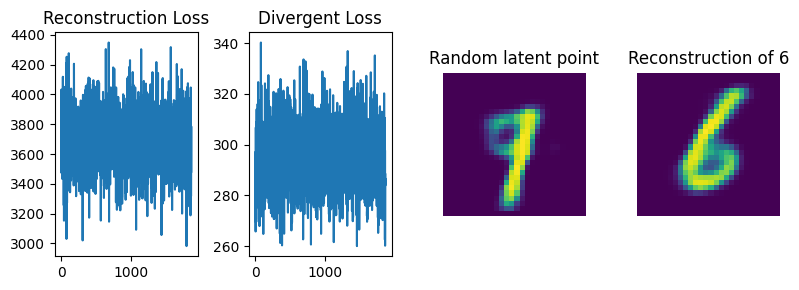

Epoch 10:


1875it [00:46, 40.52it/s, divergence_loss=300, loss=4.88e+3, reconstruction_loss=3.68e+3]


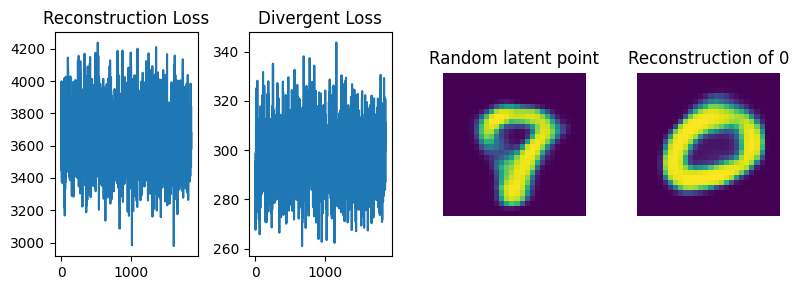

Epoch 11:


1875it [00:47, 39.70it/s, divergence_loss=294, loss=4.96e+3, reconstruction_loss=3.79e+3]


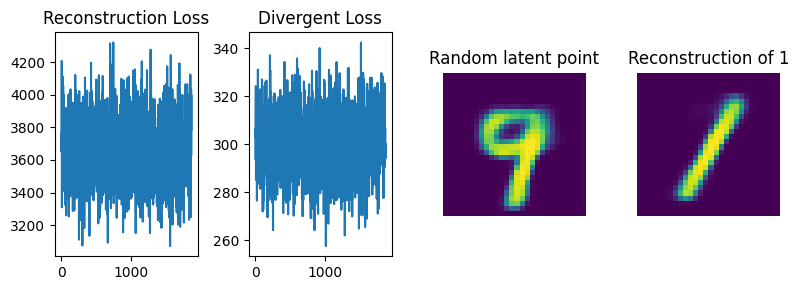

Epoch 12:


1875it [00:44, 42.48it/s, divergence_loss=282, loss=4.51e+3, reconstruction_loss=3.38e+3]


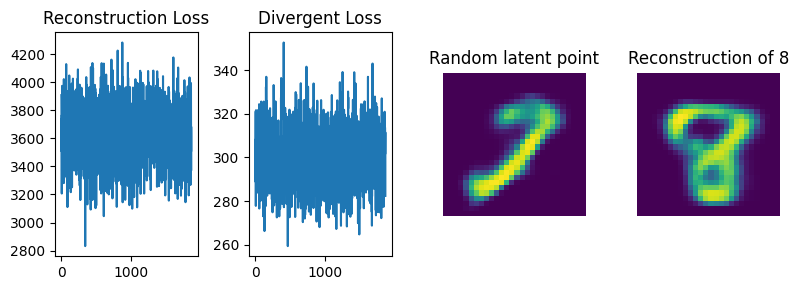

Epoch 13:


1875it [00:46, 40.70it/s, divergence_loss=305, loss=4.92e+3, reconstruction_loss=3.7e+3]


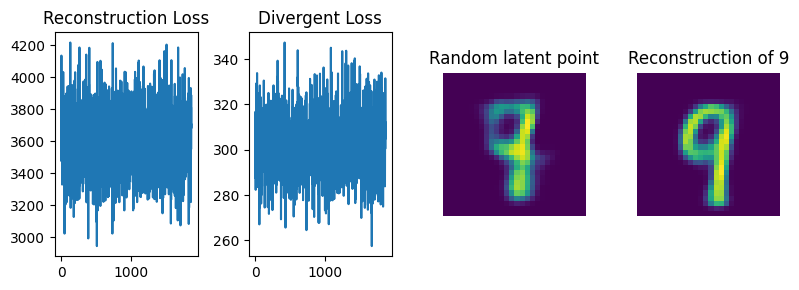

Epoch 14:


1875it [00:42, 43.82it/s, divergence_loss=299, loss=4.73e+3, reconstruction_loss=3.54e+3]


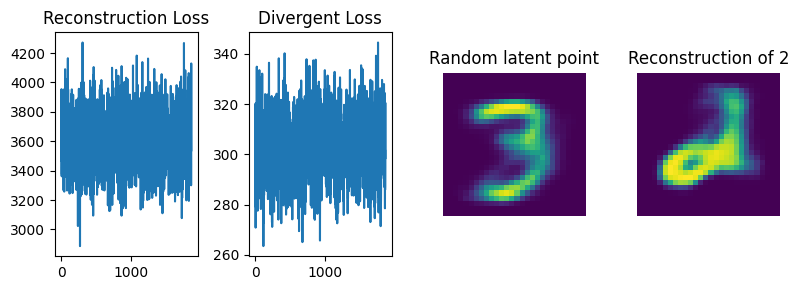

Epoch 15:


1875it [00:43, 43.22it/s, divergence_loss=297, loss=4.74e+3, reconstruction_loss=3.55e+3]


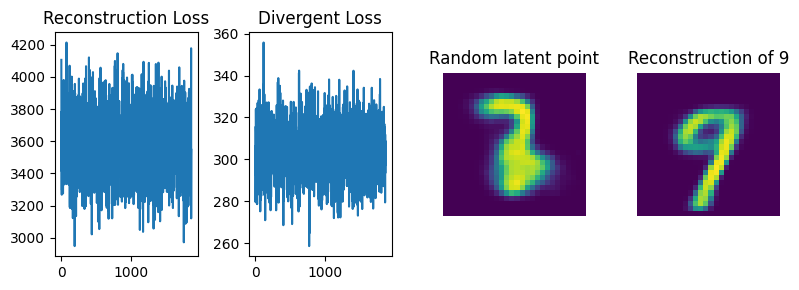

Epoch 16:


1875it [00:49, 38.09it/s, divergence_loss=297, loss=4.69e+3, reconstruction_loss=3.5e+3]


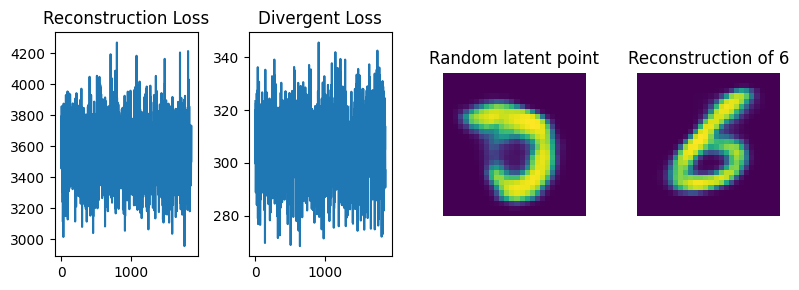

Epoch 17:


1875it [00:44, 41.92it/s, divergence_loss=298, loss=4.62e+3, reconstruction_loss=3.43e+3]


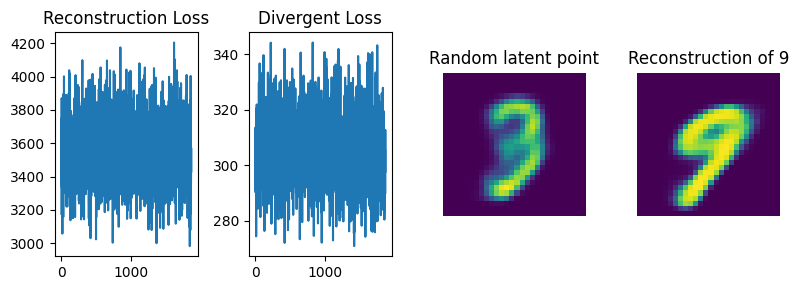

Epoch 18:


1875it [00:45, 41.54it/s, divergence_loss=310, loss=5.02e+3, reconstruction_loss=3.78e+3]


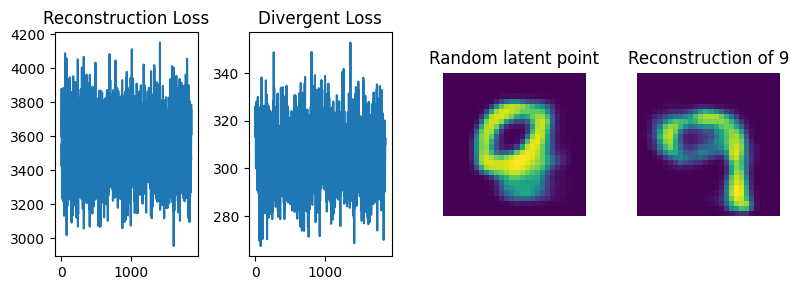

Epoch 19:


1875it [00:44, 42.23it/s, divergence_loss=313, loss=4.54e+3, reconstruction_loss=3.29e+3]


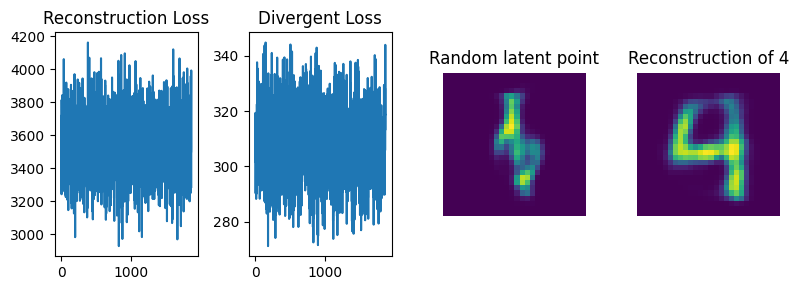

Epoch 20:


1875it [00:44, 41.90it/s, divergence_loss=301, loss=4.84e+3, reconstruction_loss=3.64e+3]


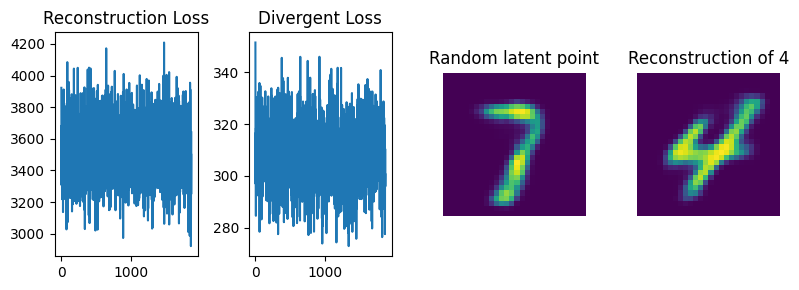

Epoch 21:


1875it [00:45, 41.34it/s, divergence_loss=305, loss=4.6e+3, reconstruction_loss=3.38e+3]


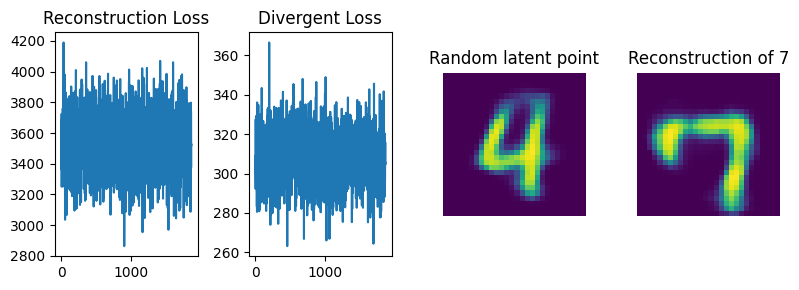

Epoch 22:


1875it [00:45, 41.58it/s, divergence_loss=324, loss=5e+3, reconstruction_loss=3.7e+3]


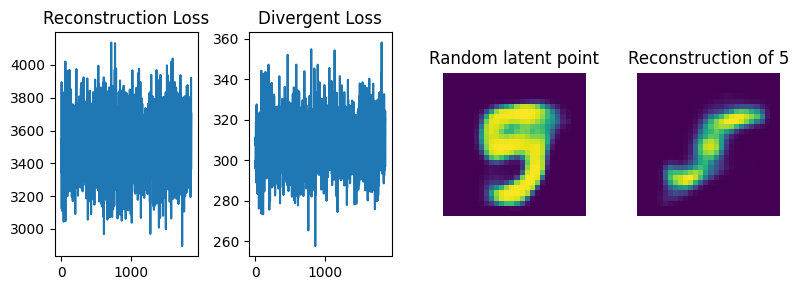

Epoch 23:


1875it [00:46, 40.72it/s, divergence_loss=280, loss=4.57e+3, reconstruction_loss=3.45e+3]


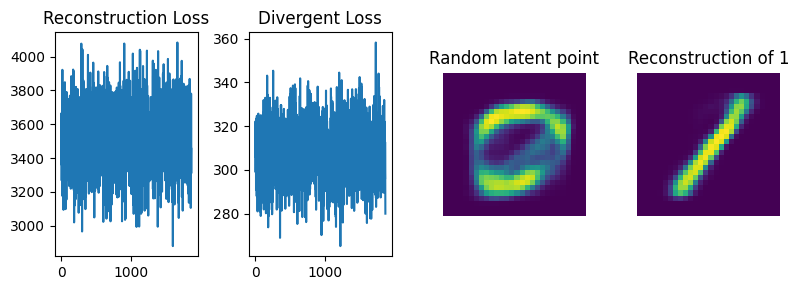

Epoch 24:


1875it [00:44, 41.85it/s, divergence_loss=303, loss=4.61e+3, reconstruction_loss=3.39e+3]


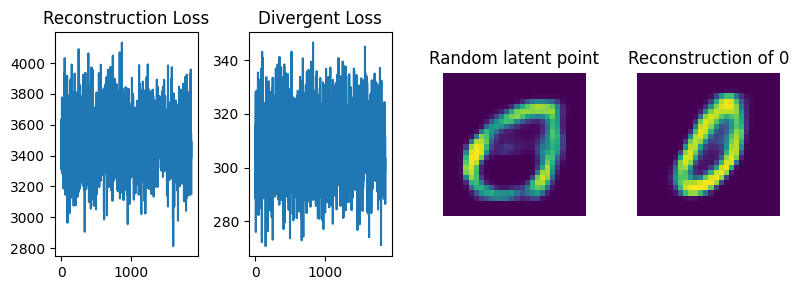

Epoch 25:


1875it [00:45, 41.02it/s, divergence_loss=315, loss=5.03e+3, reconstruction_loss=3.77e+3]


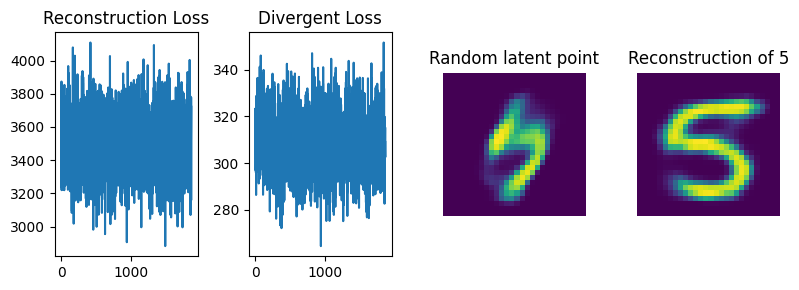

Epoch 26:


1875it [00:46, 40.28it/s, divergence_loss=292, loss=4.4e+3, reconstruction_loss=3.23e+3]


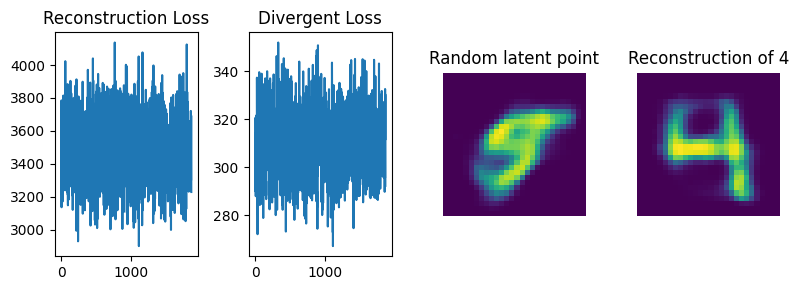

Epoch 27:


1875it [00:46, 40.65it/s, divergence_loss=311, loss=4.88e+3, reconstruction_loss=3.63e+3]


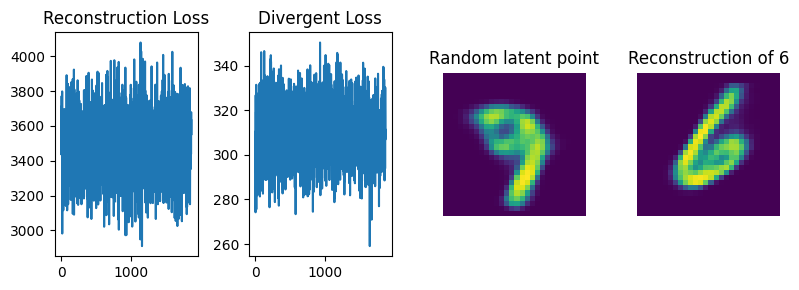

Epoch 28:


1875it [00:47, 39.76it/s, divergence_loss=303, loss=4.58e+3, reconstruction_loss=3.37e+3]


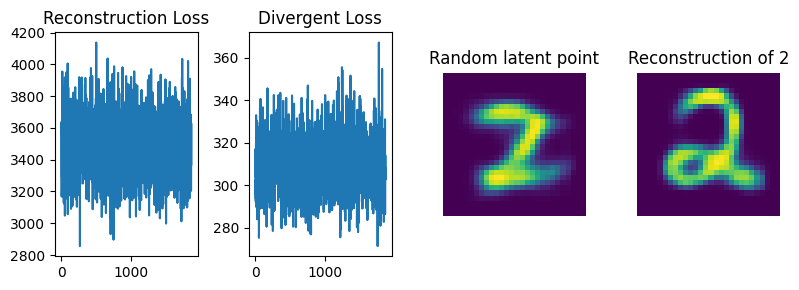

Epoch 29:


1875it [00:47, 39.40it/s, divergence_loss=305, loss=4.57e+3, reconstruction_loss=3.35e+3]


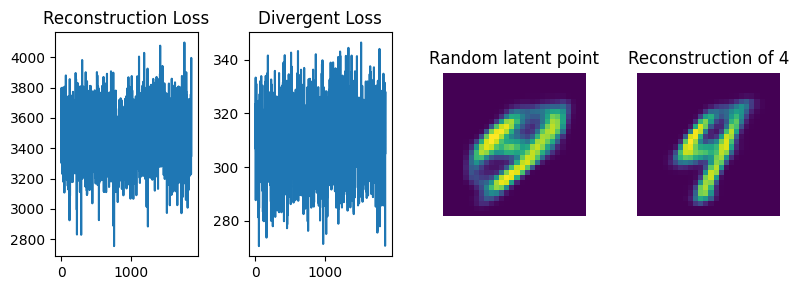

Epoch 30:


1875it [00:46, 40.67it/s, divergence_loss=302, loss=4.68e+3, reconstruction_loss=3.48e+3]


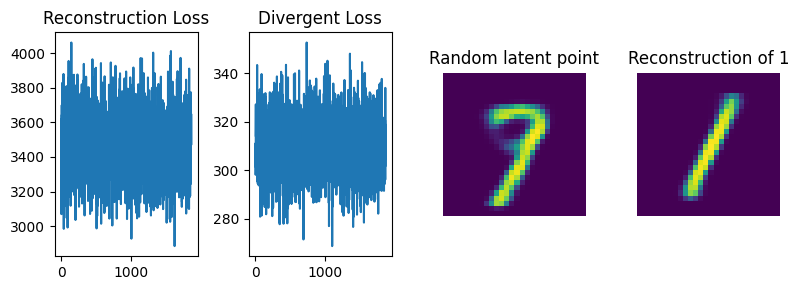

In [52]:
n_epochs = 30
beta = 4

avg_loss_lst = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}:")
    train_loop = tqdm.tqdm(enumerate(train_loader))
    model.train()
    r_loss_lst = []
    d_loss_lst = []
    for i, (X, _) in train_loop:
        X = X.to(device)
        X_hat, mu, logvar = model(X)
        loss, r_loss, d_loss = loss_fn(X, X_hat, mu, logvar, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loop.set_postfix(loss=loss.item(), reconstruction_loss=r_loss, divergence_loss=d_loss)
        r_loss_lst.append(r_loss)
        d_loss_lst.append(d_loss)
    model.eval()
    # Plot random point from the latent distribution.
    with torch.inference_mode():
        rand_img, label = random.choice(train_data)
        sample = model(rand_img.unsqueeze(0).to(device))[0]
        out = F.sigmoid(sample)
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(8, 3))
        axs[0].plot(r_loss_lst)
        axs[0].set_title("Reconstruction Loss")
        axs[1].plot(d_loss_lst)
        axs[1].set_title("Divergent Loss")
        axs[2].imshow(F.sigmoid(model.sample(1)).squeeze().cpu().numpy())
        axs[2].set_title("Random latent point")
        axs[2].axis(False)
        axs[3].imshow(out.cpu().detach().numpy().squeeze())
        axs[3].set_title(f"Reconstruction of {label}")
        axs[3].axis(False)
        fig.tight_layout()
        plt.show()
    # Earlystopping
    avg_loss = torch.mean(torch.tensor(r_loss_lst)) + beta * torch.mean(torch.tensor(d_loss_lst))
    avg_loss_lst.append(avg_loss.item())
    if early_stopper.early_stop(avg_loss.item()):
        print(f"Early Stopping at epoch {epoch+1}!")
        break

In [53]:
torch.save(model.state_dict(), f"/content/vae_beta{beta}.pt")

In [55]:
vae_model = VAE().to(device)
vae_model.load_state_dict(torch.load(f"/content/vae_beta{beta}.pt", weights_only=True))
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
  )
)

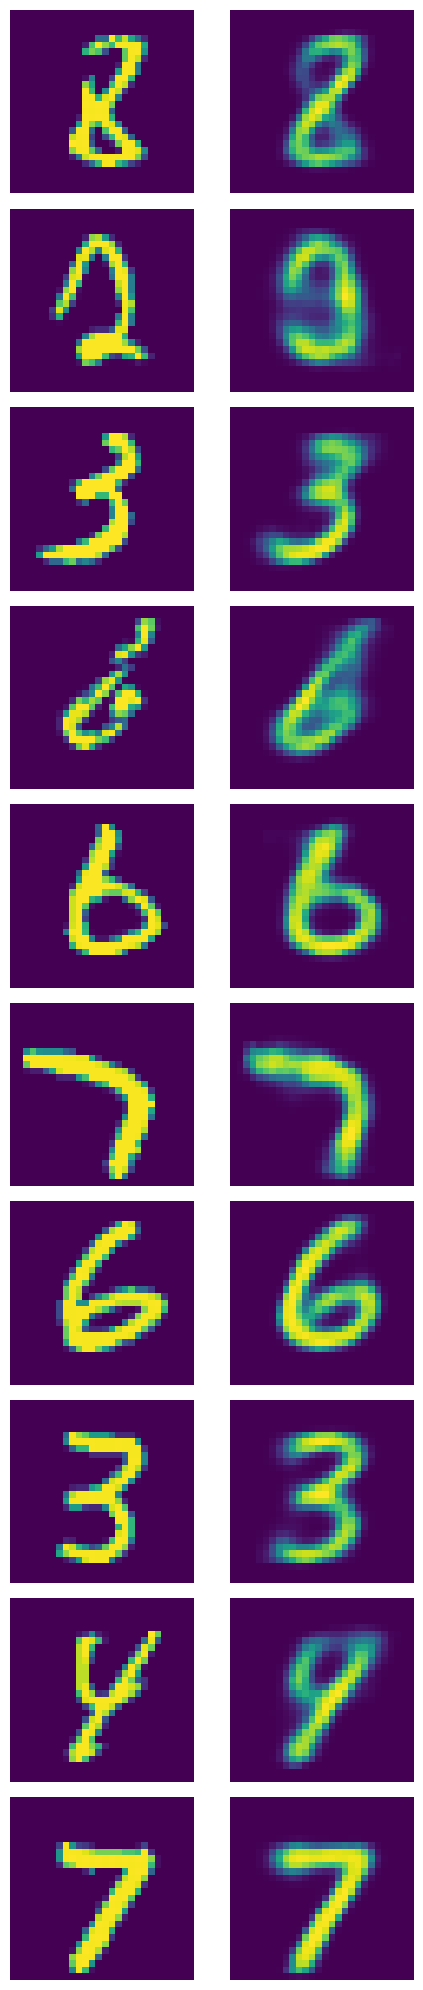

In [56]:
# Plot random reconstruction of images from test data.

num_images = 10
vae_model.eval()
with torch.inference_mode():
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(5, num_images*2))
    for i, (X, y) in enumerate(random.choices(test_data, k=num_images)):
        X_hat, _, _ = vae_model(X.to(device).unsqueeze(0))
        X_hat = F.sigmoid(X_hat).to("cpu")
        axs[i][0].imshow(X.numpy().squeeze())
        axs[i][1].imshow(X_hat.numpy().squeeze())
        axs[i][0].axis(False)
        axs[i][1].axis(False)
    fig.tight_layout()

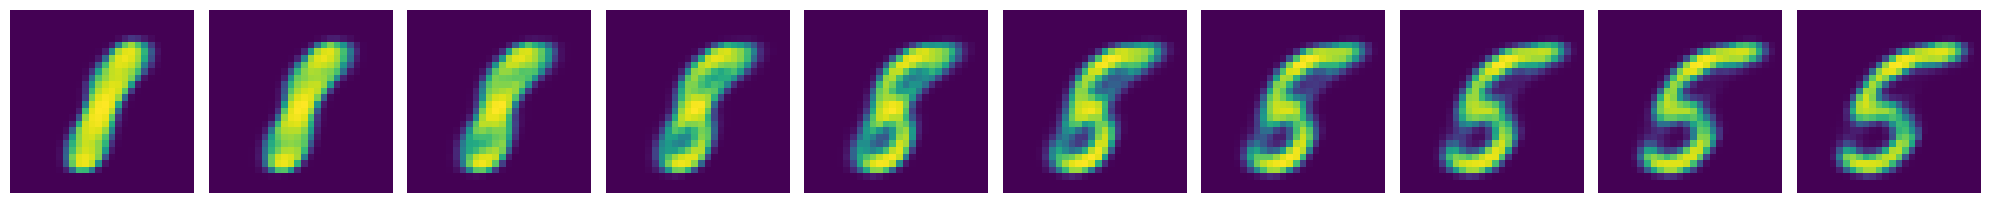

In [57]:
# Plot reconstruction of points in latent space between two random images.

num_images = 10
vae_model.eval()
with torch.inference_mode():
    point1 = vae_model.reparametrize(*vae_model.encode(random.choice(test_data)[0]))
    point2 = vae_model.reparametrize(*vae_model.encode(random.choice(test_data)[0]))
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
    for i, alpha in enumerate(torch.linspace(0, 1, steps=num_images)):
        new_point = alpha * point1 + (1 - alpha) * point2
        X_hat = vae_model.decode(new_point).view(-1, 1, 28, 28)
        X_hat = F.sigmoid(X_hat).to("cpu")
        axs[i].imshow(X_hat.numpy().squeeze())
        axs[i].axis(False)
    fig.tight_layout()

In [68]:
# Plot the activation of each dimension in latent space.

label_latent_space_dict = {}
for X, y in test_data:
    if y not in label_latent_space_dict:
        label_latent_space_dict[y] = []
    z = vae_model.reparametrize(*vae_model.encode(X.to(device))).to("cpu")
    label_latent_space_dict[y].append(z.tolist())

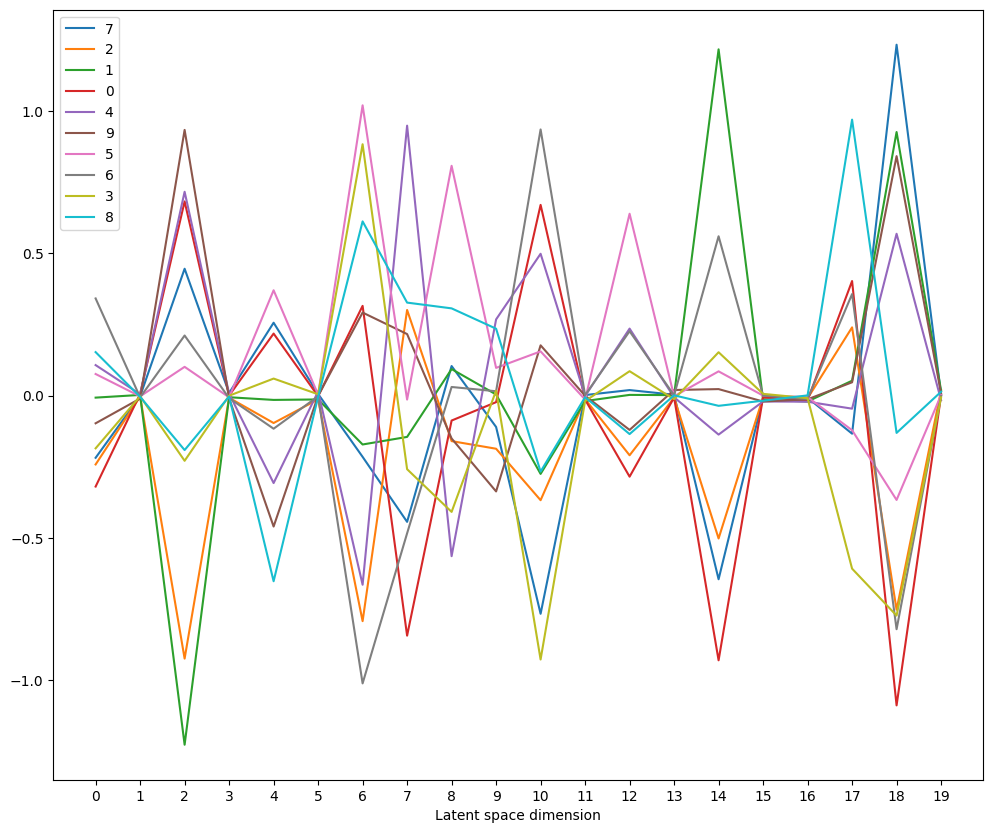

In [76]:
plt.figure(figsize=(12, 10))
z_list = []
for label, latent_space_lst in label_latent_space_dict.items():
    z = torch.mean(torch.tensor(latent_space_lst), dim=0).squeeze().tolist()
    plt.plot(z, label=label)
    z_list.append(z)
plt.legend()
plt.xlabel("Latent space dimension")
plt.xticks(ticks=range(0, 20))
plt.show()

In [ ]:
# Some of the latent spaces are not being used.
# We can further reduce the latent space for this dataset.